In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score
from gurobipy import *
import matplotlib.pyplot as plt

In [9]:
# Load the returns data frame
org_returns = pd.read_csv('org_returns.csv', index_col = 0)
# Sort the data frame based on index to be sure that it is correcly sorted
org_returns = org_returns.sort_index()

In [10]:
# Split the returns data into training, validation and test set
org_train, org_validate, org_test = np.split(org_returns,
                                             [int(.6*len(org_returns)), int(.8*len(org_returns))])

In [11]:
# Load in the files generated in the training phase
# See the SVRtrain.py file to view code used
best_accuracy = pd.read_csv('best_accuracy.csv', index_col = 0)
best_auc_score = pd.read_csv('best_auc_score.csv', index_col = 0)

In [18]:
# SVR algorithm used for prediction 
def model_SVR_pred(data, stocksymbol, window_size, C, hist, epsilon):
    temp = data.copy()
    # Create the label used for prediction
    temp[stocksymbol + '_direction'] = np.where(temp[stocksymbol] >= 0, 1, -1)
    # Get standard deviation of the index
    temp['index_std'] = temp['index'].rolling(hist).std()
    # Get standard deviation of the observed stock
    temp[stocksymbol + '_std'] = temp[stocksymbol].rolling(hist).std()
    
    # The standard deviation calculations create some NaN values so these have to be dropped
    temp = temp[hist - 1:]
    # Initialise lists and numbers
    accuracy = []
    predictions = []
    dates = []
    class_predictions = []
    class_true = []
    auc_score = 0
    
    for i in range(window_size, temp.shape[0]):
        # Select window, including the prediction terms
        total_window = temp[(i - window_size):i + 1]
        # Drop columns who do not include stock data for all days in the window
        total_window = total_window.dropna(axis='columns')
        if stocksymbol in total_window.columns:
            # Select training part
            data_window = total_window[:-1]

            # Split training part into features and labels
            Y = data_window[stocksymbol + '_direction']
            X = data_window.drop(stocksymbol + '_direction', axis=1)
            
            # Get the observation to use for prediction
            to_predict = total_window[-1:]
            
            # Split prediction part features and labels
            X_to_predict = to_predict.drop(stocksymbol + '_direction', axis=1)
            Y_to_predict = to_predict[stocksymbol + '_direction']

            # Initialise and train SVR model
            model = SVR(gamma='scale', C = C, epsilon = epsilon)
            model.fit(X, Y)
            # Get predictions
            prediction = model.predict(X_to_predict)
            # Classify predictions
            class_prediction = [1] if prediction >= 0 else [-1]
            #  Append to lists
            dates.append(str(X_to_predict.index.values[0]))
            predictions.append(float(prediction[0]))
            class_predictions.append(class_prediction)
            class_true.append(Y_to_predict)
            
            # Get accuracy of the predictions
            temp_accuracy = accuracy_score(Y_to_predict, class_prediction)
            accuracy.append(temp_accuracy)
    
    # Get the AUC score but skip it if the stock data did not cover the window size
    if len(temp[stocksymbol].dropna(axis = 0)) > window_size:
        auc_score = roc_auc_score(class_true, class_predictions)

    # Store all predictions in a data frame
    prediction_df = pd.DataFrame(predictions, index = dates, columns =[stocksymbol])
    
    # Return accuracy, AUC score and the predictions
    return(np.mean(accuracy), auc_score, prediction_df)

In [19]:
# Grid search function used for predictions
def the_gridsearch_pred(data, stocksymbol, window_size, C, hist, epsilon):
    # Create the grid in a dataframe
    params_values = [(x, y, z, t) for x in window_size for y in C 
                     for z in hist for t in epsilon]
    params = pd.DataFrame(data=params_values,# index=params_names, 
                          columns = ['window_size', 'C', 'hist', 'epsilon'])
    # Get the accuracy, auc score and regression predictions from all combination of parameters using the model_SVR_pred function
    for i in params.index:
        params.loc[params.index==i, 'accuracy'], params.loc[params.index==i, 'auc_score'], regr_predictions = model_SVR_pred(
            data, stocksymbol,
            int(params.loc[params.index==i, 'window_size']),
            float(params.loc[params.index==i, 'C']),
            int(params.loc[params.index==i, 'hist']),
            float(params.loc[params.index==i, 'epsilon']))
        
    return(params, regr_predictions)

In [14]:
# Used to fill into the parameter data frame where tuning could not be done
def auc_fill(data, auc_score_df):
    data_noindex = data.drop('index', axis = 1)
    difference = list(set(data_noindex.columns) - set(auc_score_df['symbol'].unique()))
    
    # Create temporary data frame
    new_stocks = pd.DataFrame(columns = list(auc_score_df.columns))
    
    # Check for number of non-Nan values when filling in the data frame, this keeps more stocks available for prediction
    for new_stock in difference:
        if data_noindex[new_stock].count() > 360:
            # Add the most frequent parameters from previously tuned stocks
            freq_parameters = [auc_score_df['window_size'].value_counts().idxmax(),
                      auc_score_df['C'].value_counts().idxmax(),
                      auc_score_df['hist'].value_counts().idxmax(), 0.1, 0, 0]
        elif data_noindex[new_stock].count() > 60:
            # Hardcode 180 as the window size if the stock has between 360 and 60 active days
            freq_parameters = [180, auc_score_df['C'].value_counts().idxmax(),
                      best_auc_score['hist'].value_counts().idxmax(), 0.1, 0, 0]
        else:
            # Hardcode 60 as the window size if the stock has under 60 active days, it might become active at some point of predicitons
            freq_parameters = [60, auc_score_df['C'].value_counts().idxmax(),
                      auc_score_df['hist'].value_counts().idxmax(), 0.1, 0, 0]

        freq_parameters.append(new_stock)
        new_stocks = new_stocks.append(pd.Series(dict(zip(new_stocks.columns, freq_parameters))), ignore_index=True)
    
    # Add the temporary data frame with all filled in parameters to the original parameter data frame
    auc_score_extension = pd.concat([auc_score_df, new_stocks])
    return auc_score_extension

In [24]:
# Fill in the parameter data frame
auc_score_extension = auc_fill(org_validate, best_auc_score)

# Get all columns with NaN in all rows
nan_columns = org_validate.columns[org_validate.isna().all()].tolist()
# Drop columns with NaN in all rows
org_validate_drop = org_validate.dropna(axis = 1, how = 'all')

# Get a list of stocks from the historic data
stocklist = org_validate_drop.drop('index', axis = 1).columns

# Initalise new data frames
SVR_val_predictions = pd.DataFrame()
SVR_val_scoring = pd.DataFrame()

for stock in tqdm_notebook(stocklist):
    time.sleep(0.25)
    # Get all parameters tuned for the stock
    stock_parameters = auc_score_extension[auc_score_extension['symbol'] == stock]
    window_size = stock_parameters['window_size'].values
    C = stock_parameters['C'].values
    hist = stock_parameters['hist'].values
    epsilon = stock_parameters['epsilon'].values
    
    # Add data from training set to be able to predict from the first row in validation set using the training data
    extended_data = pd.concat([org_train.drop(nan_columns, axis = 1).tail(int(window_size) + int(hist) - 1), org_validate_drop])

    # Run function to extract scorings and predictions
    SVR_scoring, SVR_predictions = the_gridsearch_pred(extended_data, stock, window_size, C, hist, epsilon)
    
    # Add predictions to the predicion data frame
    SVR_val_predictions = pd.concat([SVR_val_predictions, SVR_predictions], axis=1, sort =True)

    # Add scores to the scoring data frame
    SVR_scoring['symbol'] = stock
    SVR_val_scoring = pd.concat([SVR_val_scoring, SVR_scoring], axis = 0)

# Save both data frames for future use
SVR_val_scoring.to_csv('SVR_val_scoring.csv')
SVR_val_predictions.to_csv('SVR_val_predictions.csv')

In [29]:
# Fill in the parameter data frame
auc_score_extension = auc_fill(org_test, best_auc_score)

# Get all columns with NaN in all rows
nan_columns = org_test.columns[org_test.isna().all()].tolist()
# Drop columns with NaN in all rows
org_test_drop = org_test.dropna(axis = 1, how = 'all')

# Combine training and validation sets into a single data frame
org_trainval = pd.concat([org_train, org_validate], axis = 0)

# Get a list of stocks from the historic data
stocklist = org_test_drop.drop('index', axis = 1).columns

# Initalise new data frames
SVR_test_predictions = pd.DataFrame()
SVR_test_scoring = pd.DataFrame()

for stock in tqdm_notebook(stocklist):
    time.sleep(0.25)
    # Get all parameters tuned for the stock
    stock_parameters = auc_score_extension[auc_score_extension['symbol'] == stock]
    window_size = stock_parameters['window_size'].values
    C = stock_parameters['C'].values
    hist = stock_parameters['hist'].values
    epsilon = stock_parameters['epsilon'].values
    # Add data from validation set to be able to predict from the first row in test set using the validation data
    extended_data = pd.concat([org_trainval.drop(nan_columns, axis = 1).tail(int(window_size) + int(hist) - 1), org_test_drop])
    
    # Run function to extract scorings and predictions
    SVR_scoring, SVR_predictions = the_gridsearch_pred(extended_data, stock, window_size, C, hist, epsilon)
    
    # Add predictions to the predicion data frame
    SVR_test_predictions = pd.concat([SVR_test_predictions, SVR_predictions], axis=1, sort =True)
    
    # Add scores to the scoring data frame
    SVR_scoring['symbol'] = stock
    SVR_test_scoring = pd.concat([SVR_test_scoring, SVR_scoring], axis = 0)

# Save both data frames for future use
SVR_test_scoring.to_csv('SVR_test_scoring.csv')
SVR_test_predictions.to_csv('SVR_test_predictions.csv')

In [30]:
# Reload data if needed
SVR_val_scoring = pd.read_csv('SVR_val_scoring.csv', index_col = 0)
SVR_val_predictions = pd.read_csv('SVR_val_predictions.csv', index_col = 0)

SVR_val_scoring = pd.read_csv('SVR_test_scoring.csv', index_col = 0)
SVR_val_predictions = pd.read_csv('SVR_test_predictions.csv', index_col = 0)

In [31]:
def markowitz_optimise(data, SVR_predictions, returns_data, historical_window, penalty):
    SVR_weights = pd.DataFrame(columns = data.columns) 
    
    prev_date = ''
    for date in tqdm_notebook(SVR_predictions.index):
        time.sleep(0.25)

        current_stock_pred = SVR_predictions.loc[date].dropna()
        predicted_stocklist = current_stock_pred.index

        # Select the window we want to look at, we base it on the current prediction line
        data_window = data.loc[:date].copy()
        # We do not want to include the prediciton date since that data would be unknown when making the predictions
        data_window.drop(data_window.tail(1).index, inplace = True)

        # Only select columns that we have predictions for 
        data_window = data_window[predicted_stocklist]
        data_window = data_window.iloc[-historical_window:]
        data_window = data_window.dropna(axis = 1, how = 'any')
        stocklist = data_window.columns

        stock_volatility = data_window.std()
        stock_return = data_window.mean()
        return_cov = data_window.cov()

        std = 0.017
        n = len(stock_return)

        return_list = []
        std_list = []

        m = Model()

        max_std = std

        weight_vars = pd.Series(m.addVars(stocklist), index=stocklist)

        temp_vars_current = pd.Series(m.addVars(stocklist), index=stocklist)
        temp_vars_past = pd.Series(m.addVars(stocklist), index=stocklist)

        weight_binary = pd.Series(m.addVars(stocklist, vtype=GRB.BINARY), index=stocklist)

        portfolio_variance = return_cov.dot(weight_vars).dot(weight_vars)
        portfolio_return = stock_return.dot(weight_vars)
        if prev_date == '':
            m.setObjective(quicksum(stock_return[stock] * weight_vars[stock] * current_stock_pred[stock] for stock in stocklist), GRB.MAXIMIZE)
        else:
            m.setObjective(quicksum(stock_return[stock] * weight_vars[stock] * current_stock_pred[stock]
                                    - penalty * (temp_vars_past[stock] + temp_vars_current[stock]) for stock in stocklist), GRB.MAXIMIZE)

            m.addConstrs((SVR_weights.loc[prev_date][stock] - weight_vars[stock] == temp_vars_past[stock] - temp_vars_current[stock] for stock in stocklist), name='tester')


        m.addConstr(portfolio_variance <= max_std * max_std)
        m.addConstr(weight_vars.sum() == 1, 'budget')

        m.addConstrs((weight_vars[stock] <= weight_binary[stock] for stock in stocklist), name='lowerbound1')
        m.addConstrs((weight_vars[stock] >= 0.0001 * weight_binary[stock] for stock in stocklist), name='lowerbound2')

        m.setParam('OutputFlag', 0)
        m.update()
        m.optimize()

        return_list.append(portfolio_return.getValue())
        std_list.append(std)

        temp_weights = []
        for weight in weight_vars:
            temp_weights.append(weight.X)

        temp_series = pd.Series(dict(zip(stocklist, temp_weights)))

        temp_series.name = date

        SVR_weights = SVR_weights.append(temp_series).fillna(0)

        prev_date = date

        rel_columns = SVR_weights.columns
    
    loss = (abs(SVR_weights.diff()).sum(axis = 1) / 2) - (abs(SVR_weights.diff()).sum(axis = 1) / 2) * 0.995 * 0.995
    rel_columns = SVR_weights.columns
    profit = ((returns_data[rel_columns] + 1) * SVR_weights).sum(axis = 1)
    netto_day = profit - loss
    end_profit = netto_day.cumprod()
    
    return(end_profit[-1], SVR_weights)

In [36]:
# Grid search function
def the_gridsearch_markowitz(data, SVR_predictions, returns_data, historical_window, penalty):
    # Create the grid in a dataframe
    params_values = [(x, y) for x in historical_window for y in penalty]
    params = pd.DataFrame(data=params_values,# index=params_names, 
                              columns = ['historical_window', 'penalty'])
    # Get the profit and weights for the optimisation model
    for i in params.index:
        print('Current progress: {}%'.format(round(params.index.get_loc(i)/params.shape[0]*100, 3)))
        params.loc[params.index==i, 'profit'], SVR_weights = markowitz_optimise(
            data, SVR_predictions, returns_data,
            int(params.loc[params.index==i, 'historical_window']),
            float(params.loc[params.index==i, 'penalty']))
        
    return(params, SVR_weights)

In [43]:
# Set all parameters to use in gridsearch tuning
historical_window = [100, 250, 350, 750, 1500]
penalty = [0.001, 0.0025, 0.005, 0.0075, 0.02]

data = pd.concat([org_train, org_validate], axis = 0).drop('index', axis = 1)

# Weights are not relevant during validation phase
SVR_val_profits, trash_weights = the_gridsearch_markowitz(data, SVR_val_predictions, org_validate, historical_window, penalty)
SVR_val_profits.to_csv('SVR_val_profits.csv')

In [44]:
# Reload data if needed
SVR_val_profits = pd.read_csv('SVR_val_profits.csv', index_col = 0)
SVR_val_profits.sort_values('profit', ascending = False)

,historical_window,penalty,profit
15,750,0.0010,32.408024
20,1500,0.0010,31.769309
6,250,0.0025,2.843915
2,100,0.0050,2.737448
3,100,0.0075,1.845999
16,750,0.0025,1.713515
7,250,0.0050,1.665561
11,350,0.0025,1.590474
1,100,0.0025,1.567328
9,250,0.0200,1.448405


In [45]:
historical_window = 750
penalty = 0.001

data = org_returns.drop('index', axis = 1)
    
# Profits are not relevant during test phase
trash_profits, SVR_test_weights = markowitz_optimise(data, SVR_test_predictions, org_test, historical_window, penalty)
SVR_test_weights.to_csv('testweights_750_0.001.csv')

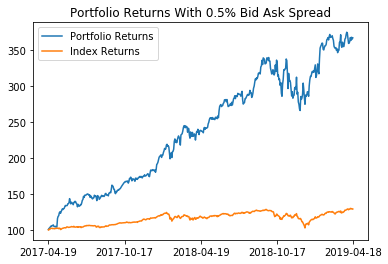

In [47]:
# Plot the change in profit based on time for the test set
SVR_test_weights = pd.read_csv('testweights_750_0.001.csv', index_col = 0)

BAspread = 0.005

loss = (abs(SVR_test_weights.diff()).sum(axis = 1) / 2) - (abs(SVR_test_weights.diff()).sum(axis = 1) / 2) * (1 - BAspread) ** 2
profit = ((org_test[SVR_test_weights.columns] + 1) * SVR_test_weights).sum(axis = 1)

end_profit = (profit - loss).cumprod() * 100
index_profit = (1 + org_test['index']).cumprod() * 100

# Get the subset of ticks for the x-axis
status = 0
subset = []
for i in range(int(len(end_profit)/126)):
    subset.append(end_profit.index[status])
    status += 126
subset.append(end_profit.index[-1])

# Plot the change in profit based on time for the test set
plt.plot(end_profit.index, end_profit, label = 'Portfolio Returns')
plt.plot(end_profit.index, index_profit, label = 'Index Returns')
plt.legend(loc='upper left')
plt.xticks(subset, visible=True, rotation="horizontal")
plt.title('Portfolio Returns With 0.5% Bid Ask Spread')
plt.savefig('0.5_BAspread.png')
plt.show()

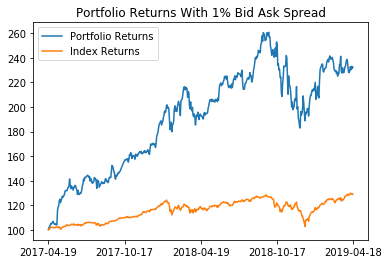

In [48]:
# Plot the change in profit based on time for the test set
SVR_test_weights = pd.read_csv('testweights_750_0.001.csv', index_col = 0)

BAspread = 0.01

loss = (abs(SVR_test_weights.diff()).sum(axis = 1) / 2) - (abs(SVR_test_weights.diff()).sum(axis = 1) / 2) * (1 - BAspread) ** 2
profit = ((org_test[SVR_test_weights.columns] + 1) * SVR_test_weights).sum(axis = 1)

end_profit = (profit - loss).cumprod() * 100
index_profit = (1 + org_test['index']).cumprod() * 100

# Get the subset of ticks for the x-axis
status = 0
subset = []
for i in range(int(len(end_profit)/126)):
    subset.append(end_profit.index[status])
    status += 126
subset.append(end_profit.index[-1])

# Plot the change in profit based on time for the test set
plt.plot(end_profit.index, end_profit, label = 'Portfolio Returns')
plt.plot(end_profit.index, index_profit, label = 'Index Returns')
plt.legend(loc='upper left')
plt.xticks(subset, visible=True, rotation="horizontal")
plt.title('Portfolio Returns With 1% Bid Ask Spread')
plt.savefig('1_BAspread.png')
plt.show()